# Trabajo Práctico 1
##### Daniel Caicedo - Ignacio Chiapella - Miguel Guerrero - Juan Knebel

In [1]:
# Para visuzalización en notebook
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
mpl.rcParams['figure.figsize'] = (8,6)
mpl.rcParams['font.size'] = 22
from IPython.display import Audio, Markdown, Image
import seaborn as sns

# Números y Datos
import numpy as np
import pandas as pd

# Archivos
import urllib.request
import glob

# Machine learning
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import normalize 

# Clustering (scipy)
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet, fcluster

# Clustering (sklearn)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))

from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import adjusted_rand_score, silhouette_score, silhouette_samples
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import euclidean_distances

from sklearn.decomposition import PCA

## Funciones para cluster

In [2]:
def silhouette_plot(data, cluster_labels, ax=None):
    '''
    Funcion que grafica el valor de silhouette por cluster
    '''
    if ax is None:
        ax = plt.gca()

    n_clusters = len(np.unique(cluster_labels))
    # Compute the silhouette scores for each sample
    silhouette_avg = silhouette_score(data, cluster_labels)
    sample_silhouette_values = silhouette_samples(data, cluster_labels)

    y_lower = padding = 2
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                         0,
                         ith_cluster_silhouette_values,
                         facecolor=color,
                         edgecolor=color,
                         alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i + 1))

        # Compute the new y_lower for next plot
        y_lower = y_upper + padding

    ax.set_xlabel("Los coeficientes de silhouette por cluster")
    ax.set_ylabel("Cluster")

    # The vertical line for average silhoutte score of all the values
    ax.axvline(x=silhouette_avg, c='r', alpha=0.8, lw=0.8, ls='-')
    ax.annotate('Silhouette avg',
                xytext=(silhouette_avg, y_lower * 1.025),
                xy=(0, 0),
                ha='center',
                alpha=0.8,
                c='r')

    ax.set_yticks([])  # Clear the yaxis labels / ticks
    ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
    ax.set_ylim(0, y_upper + 1)
    ax.set_xlim(-0.075, 1.0)
    return ax

In [3]:
def table_with_clusters_labels(classes, cluster_lables):
    '''
    Funcion que retorna la tabla cruzada de los labels de los 
    cluster vs la clase de cada uno de los elementos
    '''
    new_data_frame = pd.DataFrame({'Genero': classes, 'Clusters': cluster_lables})
    return pd.crosstab(new_data_frame['Genero'], new_data_frame['Clusters'])

In [50]:
def explore_cluster(data, classes, n_clusters, cluster, file_name):
    '''
    Funcion que inicializa las figuras y graficos que se van a mostrar
    '''
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(14, 7)

    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(data) + (n_clusters + 1) * 10])

    silhouette_by_cluster = silhouette_plot(data, cluster.labels_, ax1)
    
    plt.savefig(file_name)
    plt.show()

## Audio Features Clustering

In [5]:
metadata = pd.read_csv("../data/audio_features/metadata.csv", index_col='id')
audio_features = pd.read_csv("../data/audio_features/audio_features-reduce.csv", index_col='id')
metadata = metadata.loc[:,['album','artists','name','popularity','genre']]
audio_with_genre = pd.concat([audio_features,metadata.genre],axis=1)

audio_with_genre

,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,genre
id,,,,,,,,,,
5i2sgqnzaxYpvXmGAB592h,0.95700,0.524,0.1080,0.001230,0.1390,-18.361,0.0493,127.982,0.3220,jazz
4mGzm5ahHxMX5IhVWbU7cl,0.95300,0.480,0.0322,0.000004,0.0980,-23.781,0.0604,121.766,0.1720,jazz
4DEn3hZzSs9MFwFNDla5Y5,0.98900,0.394,0.1500,0.908000,0.3420,-21.133,0.0353,97.738,0.1700,jazz
5P6vo51dtkBYWXswH1twvK,0.17400,0.461,0.7730,0.702000,0.6920,-10.316,0.1470,130.109,0.4880,jazz
29TZQMVLv25CBm3bYn2EIQ,0.43600,0.452,0.5010,0.900000,0.1100,-13.149,0.0329,111.203,0.6020,jazz
...,...,...,...,...,...,...,...,...,...,...
6HE9tdnizI083UQwKxzQc6,0.00992,0.439,0.6370,0.264000,0.1380,-12.105,0.0456,90.012,0.1960,ambient
4UmwjnEQ4CZy9XmaN52r0I,0.84800,0.173,0.0776,0.633000,0.1330,-26.584,0.0395,72.973,0.1120,ambient
3lQk2XdEx2qgZq5R72OQa4,0.99400,0.151,0.2460,0.900000,0.1060,-17.689,0.0474,85.345,0.1360,ambient


### KMEANS

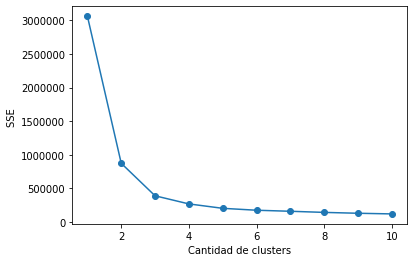

In [7]:
# calculate distortion for a range of number of cluster
distortions = []
for i in range(1, 11):
    km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    km.fit(audio_features)
    distortions.append(km.inertia_)

# plot
plt.plot(range(1, 11), distortions, marker='o')
plt.xlabel('Cantidad de clusters')
plt.ylabel('SSE ')
plt.savefig('elbow.png')
plt.show()

In [16]:
kmeans_2 = KMeans(n_clusters=2, random_state=0).fit(audio_features)
kmeans_3 = KMeans(n_clusters=3, random_state=0).fit(audio_features)
kmeans_4 = KMeans(n_clusters=4, random_state=0).fit(audio_features)
kmeans_5 = KMeans(n_clusters=5, random_state=0).fit(audio_features)
kmeans_6 = KMeans(n_clusters=6, random_state=0).fit(audio_features)

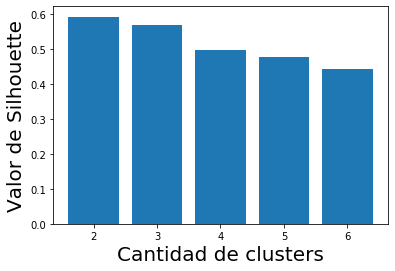

In [10]:
k = [2, 3, 4, 5, 6]

silhouette_scores = [
    silhouette_score(audio_features, kmeans_2.labels_),
    silhouette_score(audio_features, kmeans_3.labels_),
    silhouette_score(audio_features, kmeans_4.labels_),
    silhouette_score(audio_features, kmeans_5.labels_),
    silhouette_score(audio_features, kmeans_6.labels_)
]

# Plotting a bar graph to compare the results 
plt.bar(k, silhouette_scores) 
plt.xlabel('Cantidad de clusters', fontsize = 20) 
plt.ylabel('Valor de Silhouette', fontsize = 20) 
plt.savefig('silhouette-features.png')
plt.show()

In [25]:
print("Indice de rand para cluster de tamaño 2", adjusted_rand_score(audio_with_genre.genre, kmeans_2.labels_))
print("Indice de rand para cluster de tamaño 3", adjusted_rand_score(audio_with_genre.genre, kmeans_3.labels_))
print("Indice de rand para cluster de tamaño 4", adjusted_rand_score(audio_with_genre.genre, kmeans_4.labels_))
print("Indice de rand para cluster de tamaño 5", adjusted_rand_score(audio_with_genre.genre, kmeans_5.labels_))
print("Indice de rand para cluster de tamaño 6", adjusted_rand_score(audio_with_genre.genre, kmeans_6.labels_))

Indice de rand para cluster de tamaño 2 0.09838305464540162
Indice de rand para cluster de tamaño 3 0.1223709967405033
Indice de rand para cluster de tamaño 4 0.14147101360483752
Indice de rand para cluster de tamaño 5 0.1468231865651711
Indice de rand para cluster de tamaño 6 0.15289897523196652


In [24]:
cn=13
kmeans_cn = KMeans(n_clusters=cn, random_state=0).fit(audio_features)
print("Indice de rand para cluster de tamaño", cn, ":", adjusted_rand_score(audio_with_genre.genre, kmeans_cn.labels_))
silhouette_score(audio_features, kmeans_cn.labels_)

Indice de rand para cluster de tamaño 13 : 0.19130821208659848


0.41350639081342416

In [7]:
cross_table = table_with_clusters_labels(audio_with_genre.genre, kmeans_2.labels_)
cross_table

Clusters,0,1
Genero,,
ambient,121,339
classical,73,332
drum-and-bass,396,55
jazz,125,302
world-music,134,329


In [8]:
cross_table = table_with_clusters_labels(audio_with_genre.genre, kmeans_3.labels_)
cross_table

Clusters,0,1,2
Genero,,,
ambient,224,58,178
classical,253,32,120
drum-and-bass,39,359,53
jazz,159,56,212
world-music,182,62,219


In [9]:
cross_table = table_with_clusters_labels(audio_with_genre.genre, kmeans_4.labels_)
cross_table

Clusters,0,1,2,3
Genero,,,,
ambient,105,44,137,174
classical,106,32,61,206
drum-and-bass,13,358,43,37
jazz,147,51,124,105
world-music,190,49,135,89


In [10]:
cross_table = table_with_clusters_labels(audio_with_genre.genre, kmeans_5.labels_)
cross_table

Clusters,0,1,2,3,4
Genero,,,,,
ambient,90,124,43,106,97
classical,52,157,28,77,91
drum-and-bass,41,1,357,14,38
jazz,86,57,48,136,100
world-music,94,29,45,145,150


In [11]:
cross_table = table_with_clusters_labels(audio_with_genre.genre, kmeans_6.labels_)
cross_table

Clusters,0,1,2,3,4,5
Genero,,,,,,
ambient,92,38,70,79,110,71
classical,51,27,75,77,137,38
drum-and-bass,20,357,3,39,0,32
jazz,106,36,95,87,38,65
world-music,111,36,113,104,20,79


En los 3 casos aquí probados el género **drum-and-bass** fue el que mejor se clasificó. Para los demás géneros musicales el método kmeans no pareciera ser la mejor manera de clasificarlos. El problema con kmeans en este caso es que intenta generar clusters 

## Audio Analysis Clustering

In [26]:
metadata = pd.read_csv("../data/audio_analysis/metadata.csv", index_col='id')
df_timbres_avg = pd.read_csv("../data/audio_analysis/timbre_avg.csv", index_col='id')
df_timbres_std_dev = pd.read_csv("../data/audio_analysis/timbre_std_dev.csv", index_col='id')
df_pitches_avg = pd.read_csv("../data/audio_analysis/pitches_avg.csv", index_col='id')
df_pitches_std_dev = pd.read_csv("../data/audio_analysis/pitches_std_dev.csv", index_col='id')

metadata = metadata.loc[:,['album','artists','name','popularity','genre']]
df_timbres_avg_with_genre = pd.merge(left=df_timbres_avg,right=metadata['genre'], left_on='id', right_on='id')
df_timbres_std_dev_with_genre = pd.merge(left=df_timbres_std_dev,right=metadata['genre'], left_on='id', right_on='id')
df_pitches_avg_with_genre = pd.merge(left=df_pitches_avg,right=metadata['genre'], left_on='id', right_on='id')
df_pitches_std_dev_with_genre = pd.merge(left=df_pitches_std_dev,right=metadata['genre'], left_on='id', right_on='id')

### KMEANS

In [27]:
kmeans_3_timbres_avg = KMeans(n_clusters=3, random_state=0).fit(df_timbres_avg)
kmeans_3_timbres_std_dev = KMeans(n_clusters=3, random_state=0).fit(df_timbres_std_dev)
kmeans_3_pitches_avg = KMeans(n_clusters=3, random_state=0).fit(df_pitches_avg)
kmeans_3_pitches_std_dev = KMeans(n_clusters=3, random_state=0).fit(df_pitches_std_dev)

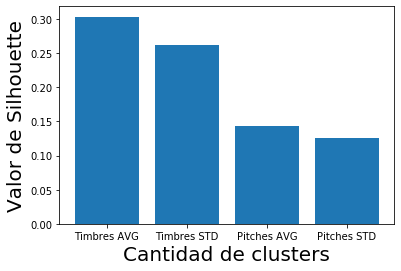

In [28]:
k = ["Timbres AVG", "Timbres STD", "Pitches AVG", "Pitches STD"]

silhouette_scores = [
    silhouette_score(df_timbres_avg, kmeans_3_timbres_avg.labels_),
    silhouette_score(df_timbres_std_dev, kmeans_3_timbres_std_dev.labels_),
    silhouette_score(df_pitches_avg, kmeans_3_pitches_avg.labels_),
    silhouette_score(df_pitches_std_dev, kmeans_3_pitches_std_dev.labels_)
]

# Plotting a bar graph to compare the results 
plt.bar(k, silhouette_scores) 
plt.xlabel('Cantidad de clusters', fontsize = 20) 
plt.ylabel('Valor de Silhouette', fontsize = 20)
plt.savefig("silhouette-analysis.png")
plt.show()

In [29]:
print("Indice de rand para cluster de timbres avg de tamaño 5", adjusted_rand_score(df_timbres_avg_with_genre.genre, kmeans_3_timbres_avg.labels_))
print("Indice de rand para cluster de timbres std de tamaño 5", adjusted_rand_score(df_timbres_std_dev_with_genre.genre, kmeans_3_timbres_std_dev.labels_))
print("Indice de rand para cluster de pitches avg de tamaño 5", adjusted_rand_score(df_pitches_avg_with_genre.genre, kmeans_3_pitches_avg.labels_))
print("Indice de rand para cluster de pitches std de tamaño 5", adjusted_rand_score(df_pitches_std_dev_with_genre.genre, kmeans_3_pitches_std_dev.labels_))

Indice de rand para cluster de timbres avg de tamaño 5 0.15132669004004193
Indice de rand para cluster de timbres std de tamaño 5 0.08432303877213608
Indice de rand para cluster de pitches avg de tamaño 5 0.09663395016248218
Indice de rand para cluster de pitches std de tamaño 5 0.03039463487744942


In [31]:
cross_table_timbres_avg = table_with_clusters_labels(df_timbres_avg_with_genre.genre, kmeans_3_timbres_avg.labels_)
cross_table_timbres_avg

Clusters,0,1,2
Genero,,,
ambient,224,197,39
classical,237,86,82
drum-and-bass,17,0,434
jazz,246,42,138
world-music,251,57,155


In [32]:
cross_table_timbres_std_dev = table_with_clusters_labels(df_timbres_std_dev_with_genre.genre, kmeans_3_timbres_std_dev.labels_)
cross_table_timbres_std_dev

Clusters,0,1,2
Genero,,,
ambient,236,51,173
classical,224,67,114
drum-and-bass,275,131,45
jazz,60,312,54
world-music,233,204,26


In [33]:
cross_table_pitches_avg = table_with_clusters_labels(df_pitches_avg_with_genre.genre, kmeans_3_pitches_avg.labels_)
cross_table_pitches_avg

Clusters,0,1,2
Genero,,,
ambient,188,123,149
classical,214,63,128
drum-and-bass,5,382,64
jazz,91,142,193
world-music,136,222,105


In [34]:
cross_table_pitches_std_dev = table_with_clusters_labels(df_pitches_std_dev_with_genre.genre, kmeans_3_pitches_std_dev.labels_)
cross_table_pitches_std_dev

Clusters,0,1,2
Genero,,,
ambient,165,137,158
classical,125,118,162
drum-and-bass,205,5,241
jazz,266,35,125
world-music,158,82,223


In [35]:
kmeans_2_avg = KMeans(n_clusters=2, random_state=0).fit(df_timbres_avg)
kmeans_3_avg = KMeans(n_clusters=3, random_state=0).fit(df_timbres_avg)
kmeans_4_avg = KMeans(n_clusters=4, random_state=0).fit(df_timbres_avg)
kmeans_5_avg = KMeans(n_clusters=5, random_state=0).fit(df_timbres_avg)
kmeans_6_avg = KMeans(n_clusters=6, random_state=0).fit(df_timbres_avg)

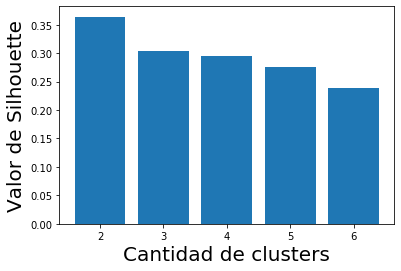

In [36]:
k = [2, 3, 4, 5, 6]

silhouette_scores = [
    silhouette_score(df_timbres_avg, kmeans_2_avg.labels_),
    silhouette_score(df_timbres_avg, kmeans_3_avg.labels_),
    silhouette_score(df_timbres_avg, kmeans_4_avg.labels_),
    silhouette_score(df_timbres_avg, kmeans_5_avg.labels_),
    silhouette_score(df_timbres_avg, kmeans_6_avg.labels_)
]

# Plotting a bar graph to compare the results 
plt.bar(k, silhouette_scores) 
plt.xlabel('Cantidad de clusters', fontsize = 20) 
plt.ylabel('Valor de Silhouette', fontsize = 20) 
plt.show()

In [37]:
print("Indice de rand para cluster de tamaño 2", adjusted_rand_score(df_timbres_avg_with_genre.genre, kmeans_2_avg.labels_))
print("Indice de rand para cluster de tamaño 3", adjusted_rand_score(df_timbres_avg_with_genre.genre, kmeans_3_avg.labels_))
print("Indice de rand para cluster de tamaño 4", adjusted_rand_score(df_timbres_avg_with_genre.genre, kmeans_4_avg.labels_))
print("Indice de rand para cluster de tamaño 5", adjusted_rand_score(df_timbres_avg_with_genre.genre, kmeans_5_avg.labels_))
print("Indice de rand para cluster de tamaño 6", adjusted_rand_score(df_timbres_avg_with_genre.genre, kmeans_6_avg.labels_))

Indice de rand para cluster de tamaño 2 0.1040320181776218
Indice de rand para cluster de tamaño 3 0.15132669004004193
Indice de rand para cluster de tamaño 4 0.23117970034778887
Indice de rand para cluster de tamaño 5 0.2325674590688895
Indice de rand para cluster de tamaño 6 0.22883135507762056


Observando los valores de silhouette, la mejor manera de clasificar a las canciones para este dataset es a traves de la media de los timbres. En los conjuntos de datos se obtuvieron valores muy bajos y viendo las tablas de como los clasificó pareciera indicar que éste método no estaría siendo el indicado para este tipo de observaciones.

## Unión de datos

Voy a unir el dataset de audio_features con audio_analysis que contien los promedios de los timbres, ya que este último dataset fue el que mejor silhoutte generó.

In [38]:
complete_feature = pd.merge(audio_features, df_timbres_avg, on='id', how='inner')
complete_feature_with_genre = pd.merge(audio_with_genre, df_timbres_avg, on='id', how='inner')

In [39]:
complete_feature

,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,0,...,2,3,4,5,6,7,8,9,10,11
id,,,,,,,,,,,,,,,,,,,,,
5i2sgqnzaxYpvXmGAB592h,0.95700,0.524,0.1080,0.001230,0.1390,-18.361,0.0493,127.982,0.3220,35.201890,...,-23.730740,-21.091840,45.662908,-15.556282,-8.880089,-7.117030,-5.495113,0.926098,-13.461626,3.098391
4mGzm5ahHxMX5IhVWbU7cl,0.95300,0.480,0.0322,0.000004,0.0980,-23.781,0.0604,121.766,0.1720,28.250467,...,-43.111475,-28.426195,41.111646,-18.658509,-26.464147,2.635676,-6.489787,-0.260614,-9.795438,0.830430
4DEn3hZzSs9MFwFNDla5Y5,0.98900,0.394,0.1500,0.908000,0.3420,-21.133,0.0353,97.738,0.1700,33.742162,...,31.613647,14.063782,30.796647,-22.728239,-13.438366,-3.469983,-12.579103,-3.535442,-4.894478,-0.382716
5P6vo51dtkBYWXswH1twvK,0.17400,0.461,0.7730,0.702000,0.6920,-10.316,0.1470,130.109,0.4880,43.169317,...,24.661216,13.889333,20.230947,-27.699563,0.120296,1.999704,-8.362748,1.382158,-7.541453,-0.739838
29TZQMVLv25CBm3bYn2EIQ,0.43600,0.452,0.5010,0.900000,0.1100,-13.149,0.0329,111.203,0.6020,42.349205,...,-39.985560,-7.126171,15.898986,-28.611521,-4.892533,-1.412859,-0.605911,0.787591,-8.569447,3.334693
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6HE9tdnizI083UQwKxzQc6,0.00992,0.439,0.6370,0.264000,0.1380,-12.105,0.0456,90.012,0.1960,43.084752,...,20.820780,-6.978655,41.551037,-38.001662,8.688520,-0.290026,0.911851,2.991038,-7.832950,-7.140990
4UmwjnEQ4CZy9XmaN52r0I,0.84800,0.173,0.0776,0.633000,0.1330,-26.584,0.0395,72.973,0.1120,32.556493,...,-42.929854,-42.517484,9.125574,-44.415882,14.656418,6.608493,4.632760,-0.507362,-2.549317,-6.497531
3lQk2XdEx2qgZq5R72OQa4,0.99400,0.151,0.2460,0.900000,0.1060,-17.689,0.0474,85.345,0.1360,39.272255,...,39.895653,-13.451055,32.812104,-27.379061,-29.541120,-6.976940,-3.893953,-5.631359,1.598355,3.946554


In [44]:
kmeans_2_all = KMeans(n_clusters=2, random_state=0).fit(complete_feature)
kmeans_3_all = KMeans(n_clusters=3, random_state=0).fit(complete_feature)
kmeans_4_all = KMeans(n_clusters=4, random_state=0).fit(complete_feature)
kmeans_5_all = KMeans(n_clusters=5, random_state=0).fit(complete_feature)
kmeans_6_all = KMeans(n_clusters=6, random_state=0).fit(complete_feature)
kmeans_7_all = KMeans(n_clusters=7, random_state=0).fit(complete_feature)
kmeans_8_all = KMeans(n_clusters=8, random_state=0).fit(complete_feature)
kmeans_9_all = KMeans(n_clusters=9, random_state=0).fit(complete_feature)
kmeans_10_all = KMeans(n_clusters=10, random_state=0).fit(complete_feature)
kmeans_11_all = KMeans(n_clusters=11, random_state=0).fit(complete_feature)
kmeans_12_all = KMeans(n_clusters=12, random_state=0).fit(complete_feature)
kmeans_13_all = KMeans(n_clusters=13, random_state=0).fit(complete_feature)
kmeans_14_all = KMeans(n_clusters=14, random_state=0).fit(complete_feature)

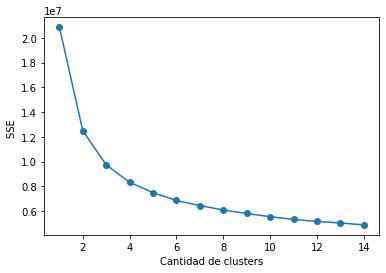

In [45]:
# calculate distortion for a range of number of cluster
distortions = []
for i in range(1, 15):
    km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    km.fit(complete_feature)
    distortions.append(km.inertia_)

# plot
plt.plot(range(1, 15), distortions, marker='o')
plt.xlabel('Cantidad de clusters')
plt.ylabel('SSE ')
plt.savefig('elbow-join.png')
plt.show()

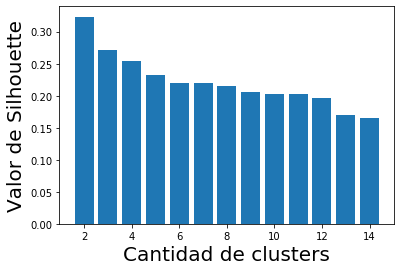

In [46]:
k = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

silhouette_scores = [
    silhouette_score(complete_feature, kmeans_2_all.labels_),
    silhouette_score(complete_feature, kmeans_3_all.labels_),
    silhouette_score(complete_feature, kmeans_4_all.labels_),
    silhouette_score(complete_feature, kmeans_5_all.labels_),
    silhouette_score(complete_feature, kmeans_6_all.labels_),
    silhouette_score(complete_feature, kmeans_7_all.labels_),
    silhouette_score(complete_feature, kmeans_8_all.labels_),
    silhouette_score(complete_feature, kmeans_9_all.labels_),
    silhouette_score(complete_feature, kmeans_10_all.labels_),
    silhouette_score(complete_feature, kmeans_11_all.labels_),
    silhouette_score(complete_feature, kmeans_12_all.labels_),
    silhouette_score(complete_feature, kmeans_13_all.labels_),
    silhouette_score(complete_feature, kmeans_14_all.labels_)
]

# Plotting a bar graph to compare the results 
plt.bar(k, silhouette_scores) 
plt.xlabel('Cantidad de clusters', fontsize = 20) 
plt.ylabel('Valor de Silhouette', fontsize = 20) 
plt.savefig("silhouette-join.png")
plt.show()

In [39]:
print("Indice de rand para cluster de tamaño 2", adjusted_rand_score(complete_feature_with_genre.genre, kmeans_2_all.labels_))
print("Indice de rand para cluster de tamaño 3", adjusted_rand_score(complete_feature_with_genre.genre, kmeans_3_all.labels_))
print("Indice de rand para cluster de tamaño 4", adjusted_rand_score(complete_feature_with_genre.genre, kmeans_4_all.labels_))
print("Indice de rand para cluster de tamaño 5", adjusted_rand_score(complete_feature_with_genre.genre, kmeans_5_all.labels_))
print("Indice de rand para cluster de tamaño 6", adjusted_rand_score(complete_feature_with_genre.genre, kmeans_6_all.labels_))

Indice de rand para cluster de tamaño 2 0.11134425806606475
Indice de rand para cluster de tamaño 3 0.18655340422914676
Indice de rand para cluster de tamaño 4 0.24565901590336045
Indice de rand para cluster de tamaño 5 0.24251504564332124
Indice de rand para cluster de tamaño 6 0.25861553649337893


In [47]:
cross_table_all_3 = table_with_clusters_labels(complete_feature_with_genre.genre, kmeans_3_all.labels_)
cross_table_all_3

Clusters,0,1,2
Genero,,,
ambient,219,22,219
classical,273,30,102
drum-and-bass,17,434,0
jazz,287,80,59
world-music,277,118,68


In [48]:
cross_table_all_4 = table_with_clusters_labels(complete_feature_with_genre.genre, kmeans_4_all.labels_)
cross_table_all_4

Clusters,0,1,2,3
Genero,,,,
ambient,83,203,17,157
classical,252,101,5,47
drum-and-bass,8,0,427,16
jazz,132,44,65,185
world-music,77,52,98,236


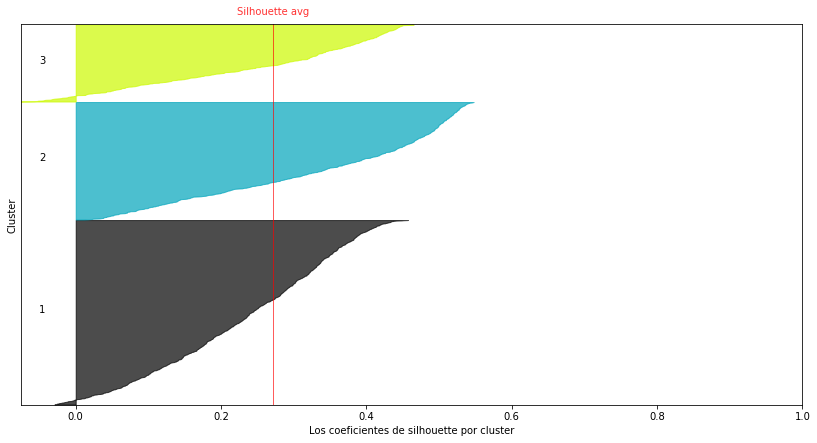

In [51]:
explore_cluster(complete_feature, complete_feature_with_genre.genre, 3, kmeans_3_all, "silhouette-join-3-eo")

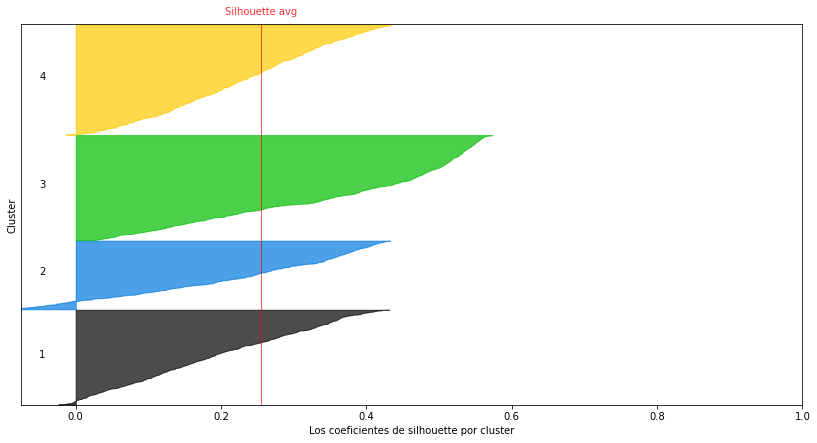

In [52]:
explore_cluster(complete_feature, complete_feature_with_genre.genre, 4, kmeans_4_all, "silhouette-join-4-eo")

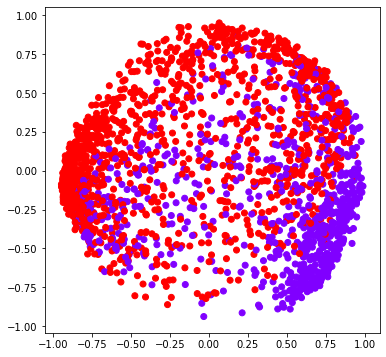

0.09838305464540162

In [29]:
# Scaling the data so that all the features become comparable 
scaler = StandardScaler() 
X_scaled = scaler.fit_transform(audio_features) 
  
# Normalizing the data so that the data approximately  
# follows a Gaussian distribution 
X_normalized = normalize(X_scaled) 
  
# Converting the numpy array into a pandas DataFrame 
X_normalized = pd.DataFrame(X_normalized) 


pca = PCA(n_components = 2) 
X_principal = pca.fit_transform(X_normalized) 
X_principal = pd.DataFrame(X_principal) 
X_principal.columns = ['P1', 'P2'] 
    
# Visualizing the clustering 
plt.figure(figsize =(6, 6)) 
plt.scatter(X_principal['P1'], X_principal['P2'],  
           c = kmeans_2.labels_, cmap ='rainbow') 
plt.show()

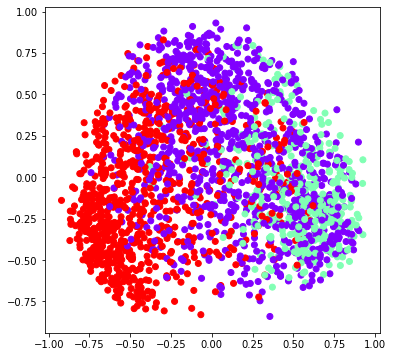

In [27]:
# Scaling the data so that all the features become comparable 
scaler = StandardScaler() 
X_scaled = scaler.fit_transform(df_timbres_avg) 
  
# Normalizing the data so that the data approximately  
# follows a Gaussian distribution 
X_normalized = normalize(X_scaled) 
  
# Converting the numpy array into a pandas DataFrame 
X_normalized = pd.DataFrame(X_normalized) 


pca = PCA(n_components = 2) 
X_principal = pca.fit_transform(X_normalized) 
X_principal = pd.DataFrame(X_principal) 
X_principal.columns = ['P1', 'P2'] 
    
# Visualizing the clustering 
plt.figure(figsize =(6, 6)) 
plt.scatter(X_principal['P1'], X_principal['P2'],  
           c = kmeans_3_avg.labels_, cmap ='rainbow') 
plt.show() 

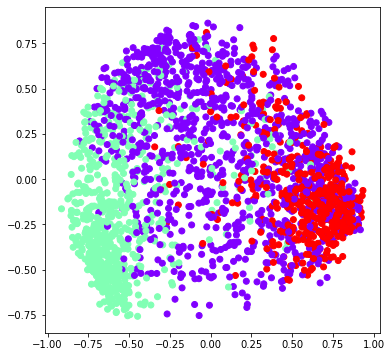

In [28]:
# Scaling the data so that all the features become comparable 
scaler = StandardScaler() 
X_scaled = scaler.fit_transform(complete_feature) 
  
# Normalizing the data so that the data approximately  
# follows a Gaussian distribution 
X_normalized = normalize(X_scaled) 
  
# Converting the numpy array into a pandas DataFrame 
X_normalized = pd.DataFrame(X_normalized) 


pca = PCA(n_components = 2) 
X_principal = pca.fit_transform(X_normalized) 
X_principal = pd.DataFrame(X_principal) 
X_principal.columns = ['P1', 'P2'] 
    
# Visualizing the clustering 
plt.figure(figsize =(6, 6)) 
plt.scatter(X_principal['P1'], X_principal['P2'],  
           c = kmeans_3_all.labels_, cmap ='rainbow') 
plt.show() 